In [2]:
import pandas as pd
import numpy as np
import os
import lightgbm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error 
from sklearn import preprocessing, metrics


from borax.calendars.lunardate import LunarDate

考虑使用china_day进行周期性趋势检验

新增年度周期

In [3]:
"""
时间变量特征
"""
def create_features(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['month'] = dataframe.China_date.dt.month  #农历月
    dataframe['day_of_month'] = dataframe.China_date.dt.day #农历日
    dataframe['day_of_year'] = dataframe.China_date.dt.dayofyear #农历的哪一天
    dataframe['week_of_year'] = dataframe.date.dt.weekofyear
    dataframe['day_of_week'] = dataframe.date.dt.dayofweek + 1
    dataframe['year'] = dataframe.date.dt.year
    dataframe['is_wknd'] = dataframe.date.dt.weekday // 4
    dataframe['is_month_start'] = dataframe.date.dt.is_month_start.astype(int)
    dataframe['is_month_end'] = dataframe.date.dt.is_month_end.astype(int)
    dataframe['quarter'] = dataframe.date.dt.quarter
    dataframe['week_block_num'] = [int(x) for x in np.floor((dataframe.date - pd.to_datetime('2017-12-31')).dt.days / 7) + 1]
    dataframe['quarter_block_num'] = (dataframe['year'] - 2018) * 4 + dataframe['quarter']
    dataframe['week_of_month'] = dataframe['week_of_year'].values // 4.35
    #dataframe['WKD_TYP_CD']=dataframe['WKD_TYP_CD'].map({'WN':0,'SN': 1, 'NH': 1, 'SS': 1, 'WS': 0})
    #新增星期几时间变量
    dataframe['is_Mon'] = np.where(dataframe['day_of_week'] == 1, 1, 0)                                                                                       
    dataframe['is_Tue'] = np.where(dataframe['day_of_week'] == 2, 1, 0)                                                                                         
    dataframe['is_Wed'] = np.where(dataframe['day_of_week'] == 3, 1, 0)                                                                                         
    dataframe['is_Thu'] = np.where(dataframe['day_of_week'] == 4, 1, 0)                                                                                         
    dataframe['is_Fri'] = np.where(dataframe['day_of_week'] == 5, 1, 0)                                                                                         
    dataframe['is_Sat'] = np.where(dataframe['day_of_week'] == 6, 1, 0)                                                                                         
    dataframe['is_Sun'] = np.where(dataframe['day_of_week'] == 7, 1, 0)
    dataframe['abs_month']=dataframe['day_of_month'].apply(lambda x: abs(x-16)+1)
    #dataframe.drop(['date','post_id'],axis=1,inplace=True)
    return dataframe

In [4]:
"""
围绕目标的分组特征、趋势性、周期性
"""
def group_features(df):
    #每年每月分组统计特征
    df['year_month_A_mean']=df.groupby(['month'])['B'].transform('mean').values
    df['year_month_A_std']=df.groupby(['month'])['B'].transform('std').values
    df['year_month_A_skew']=df.groupby(['month'])['B'].transform('skew').values
    df['year_month_A_max']=df.groupby(['month'])['B'].transform('max').values
    df['year_month_A_min']=df.groupby(['month'])['B'].transform('min').values
    df['year_month_A_median']=df.groupby(['month'])['B'].transform('median').values
    #数据倾斜分析
    df['A_minus_year_month_A_mean']=df['B']-df['year_month_A_mean']
    df['cv'] = df['year_month_A_std'] / df['year_month_A_mean']
    df['magic_feature1_1'] = df['year_month_A_median'] - df['year_month_A_mean']
    df['magic_feature1_2'] = df['magic_feature1_1'].map(abs)
    df['magic_feature2'] = df['year_month_A_median'] / df['year_month_A_mean']
    #中位数特征分析(用于分析目标与每月中位数的趋势结果)
    df['A_minus_year_month_A_median']=df['B']-df['year_month_A_median']
    df['A_ratio_year_month_A_median']=df['B'] / df['year_month_A_median']
    df['A_minus_year_month_A_mean']=df['B']-df['year_month_A_mean']
    df['A_ratio_year_month_A_mean']=df['B'] / df['year_month_A_mean']    
    #对称性分析
    df['abs_month']=df['day_of_month'].apply(lambda x: abs(x-16)+1)
    #时间序列分析中的差分结果分析
    df['year_month_A_median_diff'] = df['year_month_A_median'].diff(1)
    df['year_month_A_mean_diff'] = df['year_month_A_mean'].diff(1)
    return df


def lag_rolling_diff(df,col):
    for i in [1,2,3,5,7,15,30]:
        df['lag_'+col+'_'+str(i)] = df[col].transform(lambda x: x.shift(i))

    for j in [2,3,5,7,15,30]:    
        df['rolling_mean_'+col+'_'+str(j)] = df[col].transform(lambda x: x.shift(7).rolling(j).mean())
        
        df['new_lag_'+'rolling_mean_'+col+'_'+str(j)] = df['rolling_mean_'+col+'_'+str(j)].shift(1)

        df['rolling_std_'+col+'_'+str(j)]  = df[col].transform(lambda x: x.shift(7).rolling(j).std())
        
        df['new_lag_'+'rolling_std_'+col+'_'+str(j)] = df['rolling_std_'+col+'_'+str(j)].shift(1)        
    
    for k in [1,2,3]:
        df['diff_'+col+'_'+str(k)] = df[col].transform(lambda x: x.diff(k))
        

    
    return df


In [5]:
def yang2nong(date):
    
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    
    nong =  LunarDate.from_solar_date(year, month, day)
    
    res = nong.__format__('%y-%m-%d')
    return res

In [6]:
##lgb模型的构建
def lgb_cv(train_x, train_y, test_x):
    predictors = list(train_x.columns)
    train_x = train_x.values
    test_x = test_x.values


    folds = 10
    seed = 2021
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    train = np.zeros((train_x.shape[0]))
    test = np.zeros((test_x.shape[0]))
    test_pre = np.zeros((folds, test_x.shape[0]))
    test_pre_all = np.zeros((folds, test_x.shape[0]))
    cv_scores = []
    tpr_scores = []
    cv_rounds = []

    for i, (train_index, test_index) in enumerate(kf.split(train_x, train_y)):
        tr_x = train_x[train_index]
        tr_y = train_y[train_index]
        te_x = train_x[test_index]
        te_y = train_y[test_index]
        train_matrix = lightgbm.Dataset(tr_x, label=tr_y)
        test_matrix = lightgbm.Dataset(te_x, label=te_y)
        params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metrics':'mean_squared_error',
                'num_leaves': 2 ** 5-1,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'learning_rate': 0.1,
                #'lambda_l1': 0.01,                                                                                                                    
                #'lambda_l2': 0.01,
                'seed': 2021,


                'nthread': 20,
                'verbose': -1,


        }
        num_round = 10000
        early_stopping_rounds = 200    

        if test_matrix:
            model = lightgbm.train(params, train_matrix, num_round, valid_sets=test_matrix, verbose_eval=200,
                                #feval=tpr_eval_score,
                                early_stopping_rounds=early_stopping_rounds
                                )
            
            importance_list=[ x[0] for x in list(sorted(zip(predictors, model.feature_importance("gain")),
                        key=lambda x: x[1],reverse=True))]
            
            features_imp = pd.DataFrame(list(sorted(zip(predictors, model.feature_importance("gain")))),columns=['features','gain'])
            features_imp.to_csv('features_imp_B.csv',index=False)
            #print(A)

            
            pre = model.predict(te_x, num_iteration=model.best_iteration)#
            pred = model.predict(test_x, num_iteration=model.best_iteration)#

            train[test_index] = pre
            test_pre[i, :] = pred
            cv_scores.append(mean_squared_error (te_y, pre))
            cv_rounds.append(model.best_iteration)
            test_pre_all[i, :] = pred
           
        print("cv_score is:", cv_scores)
    use_mean=True
    if use_mean:
        test[:] = test_pre.mean(axis=0)
    else:
        pass
    print('-'*50)


    val1 = model.predict(df[select_frts].iloc[1005:1035])
    val1_rmse = np.sqrt(metrics.mean_squared_error(df['B'].iloc[1005:1035],
                                                    val1))
    print(f'loacl valid scores is {val1_rmse}')    
    
    print("val_mean:" , np.mean(cv_scores))
    print("val_std:", np.std(cv_scores))
    return train, test, test_pre_all, np.mean(cv_scores),importance_list

In [22]:
df.WKD_TYP_CD.value_counts()

0.0    809
1.0    377
Name: WKD_TYP_CD, dtype: int64

In [23]:
%time
if __name__=="__main__":
    #数据读取
    train_df=pd.read_csv('../data/train.csv')
    #将18-21年4月的节假日进行标记，如元旦、春节、清明等
    wkd = pd.read_csv('../data/new_wkd_1.csv')
    datadict = dict(zip(wkd.date,wkd.WKD_TYP_CD.values))
    train_df.columns=['date','A','B']
    
    train_df['WKD_TYP_CD']=train_df.date.map(datadict)
    train_df.fillna(0,inplace=True)
    
    train_df.date=pd.to_datetime(train_df.date)
    test_day=pd.read_csv('../data/test.csv')
    test_day.columns = ['date','A','B']
    test_day['WKD_TYP_CD']=test_day.date.map(datadict)
    test_day.fillna(0,inplace=True)    
    
    test_day.date = pd.to_datetime(test_day.date)


    df=pd.concat([train_df,test_day],axis=0)

    #进行农历转换
    df['date1'] = df.date.dt.strftime('%Y%m%d')
    df['China_date']=df['date1'].apply(lambda x: yang2nong(x))
    #农历2月不同与公历2月，
    #因此采用前向填充方式以构建pandas时间戳，难题在与20年存在的闰四月现象    
    df.replace(['2018-2-29','2018-2-30','2019-2-29',
            '2020-2-29','2020-2-30'],np.nan,inplace=True)
    
    df['China_date']=df['China_date'].fillna(method='ffill')
    df['China_date'] = pd.to_datetime(df['China_date'])

    start_day = 1035    
    
    print('*'*50)
    #选择相应的features
    select_frts=[ 'WKD_TYP_CD', 'month', 'day_of_month', 'day_of_year',
       'week_of_year', 'day_of_week', 'year', 'is_wknd', 'is_month_start',
       'is_month_end', 'quarter', 'week_block_num', 'quarter_block_num',
       'week_of_month', 'is_Mon', 'is_Tue', 'is_Wed', 'is_Thu', 'is_Fri',
       'is_Sat', 'is_Sun', 'abs_month', 'lag_B_1', 'lag_B_2', 'lag_B_3', 'lag_B_5',
       'lag_B_7','lag_B_15', 'lag_B_30','rolling_mean_B_2', 'new_lag_rolling_mean_B_2', 'rolling_std_B_2',
       'new_lag_rolling_std_B_2', 'rolling_mean_B_3',
       'new_lag_rolling_mean_B_3', 'rolling_std_B_3',
       'new_lag_rolling_std_B_3', 'rolling_mean_B_5',
       'new_lag_rolling_mean_B_5', 'rolling_std_B_5',
       'new_lag_rolling_std_B_5', 'rolling_mean_B_7',
       'new_lag_rolling_mean_B_7', 'rolling_std_B_7',
       'new_lag_rolling_std_B_7', 'rolling_mean_B_15',
       'new_lag_rolling_mean_B_15', 'rolling_std_B_15',
       'new_lag_rolling_std_B_15', 'rolling_mean_B_30',
       'new_lag_rolling_mean_B_30', 'rolling_std_B_30',
       'new_lag_rolling_std_B_30',
       ]
    
    #df.iloc[1035:1036]['A']=df.iloc[1034:1035]['A']
    for j in range(90): 
        df=create_features(df)
        df = group_features(df)
        df = lag_rolling_diff(df,'B')
        print(f'开始第{j+1}天的预测')
        train_day_df_B = df[:start_day+j]  #此时需要动态构建训练集与测试集
        test_day_df_B = df[start_day+j:start_day+j+1]  #start_day + for 循环


        train_df=train_day_df_B.reset_index(drop=True)#训练集A
        #试试从19年6月开始预测
        train_df=train_df[train_df['date']>='2019-06-01'].reset_index(drop=True)
        test_df=test_day_df_B[0:1]#测试集A
        train_x = train_df[select_frts].copy()
        train_y = train_df['B']
        test_x = test_df[select_frts].copy()
        print(train_x.shape,train_y.shape,test_x.shape)
        lgb_train, lgb_test, sb, cv_scores, importance_list = lgb_cv(train_x, train_y, test_x)
        lgb_test_B=[item if item>0 else 0 for item in lgb_test]
        pre_B=np.array(lgb_test_B)
        print(f'第{j+1}天的预测值为{pre_B}')

        df[start_day+j:start_day+j+1]['B'] = lgb_test_B

Wall time: 0 ns
**************************************************


C:\Users\28947\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


开始第1天的预测
(519, 53) (519,) (1, 53)
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 1.08307e+08
Early stopping, best iteration is:
[118]	valid_0's l2: 1.06371e+08
cv_score is: [106371368.69939083]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 1.81099e+08
Early stopping, best iteration is:
[45]	valid_0's l2: 1.71856e+08
cv_score is: [106371368.69939083, 171856487.71246493]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 9.37789e+07
Early stopping, best iteration is:
[37]	valid_0's l2: 8.64493e+07
cv_score is: [106371368.69939083, 171856487.71246493, 86449331.66581543]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 6.80669e+07
Early stopping, best iteration is:
[32]	valid_0's l2: 6.50825e+07
cv_score is: [106371368.69939083, 171856487.71246493, 86449331.66581543, 65082468.69808838]
Training until validation scores don't improve for 200 rounds
[200]	vali

C:\Users\28947\Anaconda\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\28947\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':



(520, 53) (520,) (1, 53)
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 1.47122e+08
Early stopping, best iteration is:
[157]	valid_0's l2: 1.44921e+08
cv_score is: [144921089.9646783]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 6.35149e+07
Early stopping, best iteration is:
[94]	valid_0's l2: 6.14705e+07
cv_score is: [144921089.9646783, 61470547.6941092]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 1.55155e+08
Early stopping, best iteration is:
[54]	valid_0's l2: 1.5142e+08
cv_score is: [144921089.9646783, 61470547.6941092, 151420045.47365963]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 6.81977e+07
Early stopping, best iteration is:
[44]	valid_0's l2: 6.30423e+07
cv_score is: [144921089.9646783, 61470547.6941092, 151420045.47365963, 63042287.778480604]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 5.0740

C:\Users\28947\Anaconda\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\28947\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


开始第3天的预测
(521, 53) (521,) (1, 53)
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 2.0784e+08
Early stopping, best iteration is:
[103]	valid_0's l2: 2.06313e+08
cv_score is: [206312945.98428345]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 5.38025e+07
Early stopping, best iteration is:
[40]	valid_0's l2: 4.84365e+07
cv_score is: [206312945.98428345, 48436545.89373451]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 6.92175e+07
Early stopping, best iteration is:
[70]	valid_0's l2: 6.70553e+07
cv_score is: [206312945.98428345, 48436545.89373451, 67055314.861650616]
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l2: 8.32849e+07
Early stopping, best iteration is:
[36]	valid_0's l2: 8.05981e+07
cv_score is: [206312945.98428345, 48436545.89373451, 67055314.861650616, 80598134.7713669]
Training until validation scores don't improve for 200 rounds
[200]	valid_0

KeyboardInterrupt: 

In [ ]:
loacl valid scores is 4795.8228732489215
val_mean: 106375486.51705734
val_std: 58422696.84308371
第1天的预测值为[237347.67595194]

loacl valid scores is 3508.660810653456
val_mean: 98581070.37479173
val_std: 60460861.65178677
第2天的预测值为[243637.45799149]

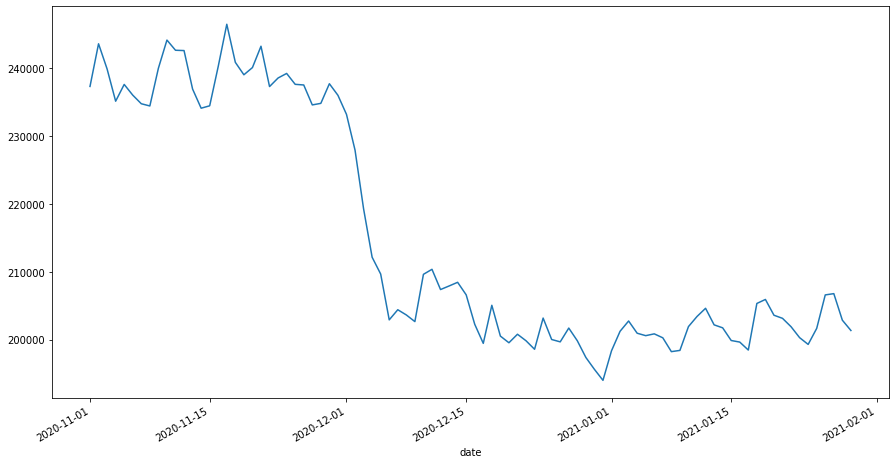

In [19]:
df1 = df[1035:1035+90][['date','B']]
df1.index=df1.date

with pd.plotting.plot_params.use('x_compat', True):
    df1['B'].plot(y=df1['B'],figsize=(15,8))

In [20]:
df1 = df[1035:][['date','B']]
df1

,date,B
0,2020-11-01,237347.675952
1,2020-11-02,243637.457991
2,2020-11-03,239925.276066
3,2020-11-04,235169.958565
4,2020-11-05,237643.335812
...,...,...
146,2021-03-27,0.000000
147,2021-03-28,0.000000
148,2021-03-29,0.000000
149,2021-03-30,0.000000


In [21]:
df1.to_csv('./data/daybyday_new_group_features_B.csv',index=False)

In [22]:
df2=pd.read_csv('./data/daybyday_new_group_features_A.csv')
df2

,date,A
0,2020-11-01,270338.039043
1,2020-11-02,269113.663029
2,2020-11-03,269197.652956
3,2020-11-04,267300.493228
4,2020-11-05,266541.020046
...,...,...
146,2021-03-27,0.000000
147,2021-03-28,0.000000
148,2021-03-29,0.000000
149,2021-03-30,0.000000


In [23]:
test_v11 = pd.read_csv('../data/test.csv')
test_v11

,日期,A厂,B厂
0,2020/11/01,0,0
1,2020/11/02,0,0
2,2020/11/03,0,0
3,2020/11/04,0,0
4,2020/11/05,0,0
...,...,...,...
146,2021/03/27,0,0
147,2021/03/28,0,0
148,2021/03/29,0,0
149,2021/03/30,0,0


In [24]:
test_v11['A厂']=df2.A
test_v11['B厂']=df1.B
test_v11

,日期,A厂,B厂
0,2020/11/01,270338.039043,237347.675952
1,2020/11/02,269113.663029,243637.457991
2,2020/11/03,269197.652956,239925.276066
3,2020/11/04,267300.493228,235169.958565
4,2020/11/05,266541.020046,237643.335812
...,...,...,...
146,2021/03/27,0.000000,0.000000
147,2021/03/28,0.000000,0.000000
148,2021/03/29,0.000000,0.000000
149,2021/03/30,0.000000,0.000000


In [25]:
test_v11.to_csv('./data/test_new1.csv',index=False)

In [26]:
df3 = pd.read_csv('./data/test_new1.csv')
df3.columns=['date','A','B']
df3

,date,A,B
0,2020/11/1,270338.0390,237347.6760
1,2020/11/2,269113.6630,243637.4580
2,2020/11/3,269197.6530,239925.2761
3,2020/11/4,267300.4932,235169.9586
4,2020/11/5,266541.0200,237643.3358
...,...,...,...
146,2021/3/27,296200.0000,254474.0000
147,2021/3/28,298541.0000,255556.0000
148,2021/3/29,304362.0000,256910.0000
149,2021/3/30,303664.0000,256423.0000


In [27]:
test_v11 = pd.read_csv('../data/test.csv')
test_v11

,日期,A厂,B厂
0,2020/11/01,0,0
1,2020/11/02,0,0
2,2020/11/03,0,0
3,2020/11/04,0,0
4,2020/11/05,0,0
...,...,...,...
146,2021/03/27,0,0
147,2021/03/28,0,0
148,2021/03/29,0,0
149,2021/03/30,0,0


In [28]:
test_v11['A厂']=df3['A'].astype(int)
test_v11['B厂']=df3['B'].astype(int)
test_v11

,日期,A厂,B厂
0,2020/11/01,270338,237347
1,2020/11/02,269113,243637
2,2020/11/03,269197,239925
3,2020/11/04,267300,235169
4,2020/11/05,266541,237643
...,...,...,...
146,2021/03/27,296200,254474
147,2021/03/28,298541,255556
148,2021/03/29,304362,256910
149,2021/03/30,303664,256423


In [29]:
test_v11.to_csv('./data/lgb_stepbystep_90_and_guonian_from2019_6_addrollinglag.csv',index=False,encoding='utf-8')

In [30]:
test_v11[(test_v11['日期']>='2020/12/01')&(test_v11['日期']<='2020/12/31')]

,日期,A厂,B厂
30,2020/12/01,210837,221413
31,2020/12/02,210768,220151
32,2020/12/03,210280,220791
33,2020/12/04,209872,220235
34,2020/12/05,212547,218429
35,2020/12/06,213274,217804
36,2020/12/07,210047,221147
37,2020/12/08,209403,220795
38,2020/12/09,209935,218993
39,2020/12/10,209448,218605


In [56]:
test_v11 = pd.read_csv('./data/lgb_stepbystep_without_1_2_2020.csv')
test_v11

,日期,A厂,B厂
0,2020/11/01,272374,234141
1,2020/11/02,268795,239837
2,2020/11/03,265203,241281
3,2020/11/04,263442,242709
4,2020/11/05,261568,242040
...,...,...,...
146,2021/03/27,264465,212062
147,2021/03/28,266555,212964
148,2021/03/29,271752,214092
149,2021/03/30,271129,213686


In [57]:
test_v11[(test_v11['日期']>='2020/12/01')&(test_v11['日期']<='2020/12/31')]

,日期,A厂,B厂
30,2020/12/01,210837,221413
31,2020/12/02,210768,220151
32,2020/12/03,210280,220791
33,2020/12/04,209872,220235
34,2020/12/05,212547,218429
35,2020/12/06,213274,217804
36,2020/12/07,210047,221147
37,2020/12/08,209403,220795
38,2020/12/09,209935,218993
39,2020/12/10,209448,218605


In [61]:
test_v11[(test_v11['日期']>='2020/12/01')&(test_v11['日期']<='2020/12/31')]

,日期,A厂,B厂,A
30,2020/12/01,210837,221413,210837.00
31,2020/12/02,210768,220151,242383.20
32,2020/12/03,210280,220791,241822.00
33,2020/12/04,209872,220235,241352.80
34,2020/12/05,212547,218429,244429.05
35,2020/12/06,213274,217804,245265.10
36,2020/12/07,210047,221147,241554.05
37,2020/12/08,209403,220795,240813.45
38,2020/12/09,209935,218993,241425.25
39,2020/12/10,209448,218605,240865.20


In [62]:
test_v11

,日期,A厂,B厂,A
0,2020/11/01,272374,234141,272374.0
1,2020/11/02,268795,239837,268795.0
2,2020/11/03,265203,241281,265203.0
3,2020/11/04,263442,242709,263442.0
4,2020/11/05,261568,242040,261568.0
...,...,...,...,...
146,2021/03/27,264465,212062,264465.0
147,2021/03/28,266555,212964,266555.0
148,2021/03/29,271752,214092,271752.0
149,2021/03/30,271129,213686,271129.0


In [68]:
test_v111 = pd.read_csv('./data/lgb_stepbystep_without_1_2_20201.15.csv')
test_v111.columns=['日期','A厂','B厂']
test_v111

,日期,A厂,B厂
0,2020/11/1,272374.0,234141
1,2020/11/2,268795.0,239837
2,2020/11/3,265203.0,241281
3,2020/11/4,263442.0,242709
4,2020/11/5,261568.0,242040
...,...,...,...
146,2021/3/27,264465.0,212062
147,2021/3/28,266555.0,212964
148,2021/3/29,271752.0,214092
149,2021/3/30,271129.0,213686


In [69]:
test_v11 = pd.read_csv('./data/test.csv')
test_v11

,日期,A厂,B厂
0,2020/11/01,0,0
1,2020/11/02,0,0
2,2020/11/03,0,0
3,2020/11/04,0,0
4,2020/11/05,0,0
...,...,...,...
146,2021/03/27,0,0
147,2021/03/28,0,0
148,2021/03/29,0,0
149,2021/03/30,0,0


In [71]:
test_v11['A厂'] = test_v111['A厂'].astype(int)
test_v11['B厂'] = test_v111['B厂'].astype(int)
test_v11

,日期,A厂,B厂
0,2020/11/01,272374,234141
1,2020/11/02,268795,239837
2,2020/11/03,265203,241281
3,2020/11/04,263442,242709
4,2020/11/05,261568,242040
...,...,...,...
146,2021/03/27,264465,212062
147,2021/03/28,266555,212964
148,2021/03/29,271752,214092
149,2021/03/30,271129,213686


In [72]:
test_v11.to_csv('./data/lgb_stepbystep_without_1_2_2020_mult15.csv',index=False,encoding='utf-8')

In [74]:
test_v111 = pd.read_csv('./data/lgb_stepbystep_without_1_2_2020_1.csv')
test_v111.columns=['日期','A厂','B厂']
test_v111

,日期,A厂,B厂
0,2020/11/1,272374.00,234141.0
1,2020/11/2,268795.00,239837.0
2,2020/11/3,265203.00,241281.0
3,2020/11/4,263442.00,242709.0
4,2020/11/5,261568.00,242040.0
...,...,...,...
146,2021/3/27,277688.25,233268.2
147,2021/3/28,279882.75,234260.4
148,2021/3/29,285339.60,235501.2
149,2021/3/30,284685.45,235054.6


In [75]:
test_v11 = pd.read_csv('./data/test.csv')
test_v11['A厂'] = test_v111['A厂'].astype(int)
test_v11['B厂'] = test_v111['B厂'].astype(int)
test_v11

,日期,A厂,B厂
0,2020/11/01,272374,234141
1,2020/11/02,268795,239837
2,2020/11/03,265203,241281
3,2020/11/04,263442,242709
4,2020/11/05,261568,242040
...,...,...,...
146,2021/03/27,277688,233268
147,2021/03/28,279882,234260
148,2021/03/29,285339,235501
149,2021/03/30,284685,235054


In [76]:
test_v11.to_csv('./data/lgb_stepbystep_without_1_2_2020_multguonian.csv',index=False,encoding='utf-8')

过年，A*1.5，B*1.1   从初六开始

过年，A1.1，B1.15 从初六开始 分数最高